<a href="https://colab.research.google.com/github/tarabelo/PIAC-2526/blob/main/06_B%C3%BAsqueda_adaptativa_de_Grover_(GAS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit[visualization]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 99.3 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=914d1fef49414c68ca82722b88a7626fca6a56a7810cecf176fd99e28a851e33
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


# **Búsqueda adaptativa de Grover (GAS)**

### Contenidos

1. [Algoritmo GAS](gas)
1. [Implementación del oráculo](#oraculo)
1. [Suma en el dominio de Fourier (_phase encoding_)](#suma)
1. [Implementación del oráculo (continuación)](#oraculocont)
1. [Uso con el algoritmo de Grover](#grover)

<a name="gas"></a>

# **Algoritmo GAS**

Presentado en 1966 (https://arxiv.org/abs/quant-ph/9607014) busca encontrar el mínimo de una función $g(x)$ usando el algoritmo de búsqueda de Grover.

El proceso es como sigue:

1. Se elige un valor $x_0$ aleatorio y se computa $g(x_0)$
1. Se define un oráculo $f:\{0,1\}^n \rightarrow \{0,1\}$ de la forma:
$$
f(y) =
\begin{cases}
1, \text{si } g(y) < g(x_0)\\
0, \text{si } \text{ en otro caso}
\end{cases}
$$
1. Se usa el algoritmo de Grover para encontrar un $y$ ($\mathcal{O}\left(\sqrt{2^n}\right)$ evaluaciones).
1. Se hace $x_0=y$ y se vuelve al punto 2 hasta encontrar el mínimo.



---



---



---



<a name="oraculo"></a>

# **Implementación del oráculo**

El oráculo GAS puede ser complejo de implementar.

Para una función QUBO es más simple.


### **Ejemplo**: Implementación de la función $g(x)=-2x_0x_2-x_1x_2-x_0+2x_1-3x_2$

Necesitamos 3 cúbits para representar las $x$.

Es fácil ver que $-7 \le g(x) \le 2$, por lo que necesitamos un mínimo de 4 bits para representar las $g(x).

Un ejemplo de circuito:

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1IZPRKNSCJH4xcuNedx6iJMB8VU--OaOW" alt="Ejemplo oraculo GAS" width="700"  /></center>
<br>

Necesitamos implementar las puertas de suma.




---



---



---



<a name="suma"></a>

# **Suma en el dominio de Fourier (_phase encoding_)**

Para hacer la suma, podemos codificar los coeficientes mediante codificación en la fase.

Así, un número entero $j$ de $n$-bits tiene la siguiente codificación:

$$
\text{QFT}(|j\rangle) = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \exp\left(\frac{2\pi i}{2^n}jk\right)|k\rangle
$$

Por ejemplo, el 0 se representa como:

$$
\frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n-1} \exp\left(\frac{2\pi i}{2^n}0j\right)|j\rangle = \frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n-1} |j\rangle
$$

Ya que la QFT de $|0\rangle$ es $|+\rangle^{\otimes n}$


Sea un entero $j \ge 0$ codificado en la fase al que queremos sumarle otro entero no negativo $l$ para obtener:

$$
\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \exp\left(\frac{2\pi i}{2^n}(j+l)k\right)|k\rangle
$$

Esta suma se puede hacer con puertas fase como se muestra en el siguiente circuito:

<center><img src="https://drive.google.com/uc?export=view&id=1ZSkZZhdM9KLNMvITQbro4ic9yYxcPuPU" alt="Suma phase encoding" width="300"  /></center>

Es decir, al cúbit $k_h$ se le aplica la puerta

$$
P\!\left(\frac{\pi}{2^{n-1-h}}\,l\right)
$$



## Funcionamiento
Sea $|k\rangle = |k_{n-1}\ldots k_0\rangle$ un estado base. Sea $k_h\in\{0,1\}$ el bit $h$-ésimo:

- Si el qubit $k_h$ vale 0 → la puerta no introduce fase.  
- Si el qubit $k_h$ vale 1 → añade fase  $\exp\left(\frac{i\pi\,l}{2^{n-1-h}}\right)$.


El estado $|k\rangle$ recibe por tanto la fase total:

$$
\prod_{h=0}^{n-1}
\exp\left(\frac{i \pi l\, k_h}{2^{n-1-h}}\right)
=
\exp\left({i\pi l \sum_{h=0}^{n-1} \frac{k_h}{2^{n-1-h}}}\right).
$$

Usando la expansión binaria, el entero $k$ se puede escribir:

$$
k = \sum_{h=0}^{n-1} k_h 2^h \implies \frac{k}{2^{n-1}} = \sum_{h=0}^{n-1} \frac{k_h}{2^{n-1-h}}
$$


Por tanto, la fase total aplicada resulta:

$$
\exp\left(\frac{i \pi l k}{2^{n-1}}\right)
= \exp\left(\frac{2i \pi l k}{2^{n}}\right).
$$

## Resultado final
Aplicar este circuito a un entero $j$ codificado en la fase como

$$
\frac{1}{\sqrt{2^n}}
\sum_{k=0}^{2^{n-1}} \exp\left(\frac{2\pi i}{2^n}jk\right)|k\rangle
$$

produce:

$$
\boxed{
\frac{1}{\sqrt{2^n}}
\sum_{k=0}^{2^{n-1}} \exp\left(\frac{2\pi i}{2^n}(j+l)k\right)|k\rangle
}
$$

lo cual implementa la suma de enteros en codificación de fase.

Aplicando la QFT inversa:

$$
\text{QFT}^{-1}\left(\frac{1}{\sqrt{2^n}}
\sum_{k=0}^{2^{n-1}} \exp\left(\frac{2\pi i}{2^n}(j+l)k\right)|k\rangle\right) = j+l
$$

### Números negativos

Usando complemento a 2 para representar enteros negativos, la representación binaria de $l\lt 0$ es:

$$
l = 2^n-|l| = 2^n + l
$$

Por lo tanto, la fase aplicada por el circuito anterior al $h$-ésimo bit será:

$$
\exp\left(\frac{i\pi(2^n+l)}{2^{n-1-h}}\right) = \exp\left(\frac{i\pi\,2^n}{2^{n-1-h}}\right) \exp\left(\frac{i\pi\,l}{2^{n-1-h}}\right) = \exp\left(\frac{i\pi\,l}{2^{n-1-h}}\right).
$$

ya que:

$$
\exp\left(\frac{i\pi\,2^n}{2^{n-1-h}}\right) = \exp\left(i\pi\,2^{h+1}\right) = 1
$$

Es decir, el circuito nos sirve para números negativos y positivos.

**Ejemplo**: Función que devuelve una puerta que suma un entero $l$ en phase encoding

In [2]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit import Gate
import numpy as np

def pAddGate(l: int, n: int) -> Gate:
  """
  Devuelve un qiskit.circuit.Gate que ejecuta una suma +l en el dominio de Fourier
  de un valor entero de n cúbits.
  n debe ser suficientemente grande para representar el valor de la suma

  Argumentos:
    l: valor a sumar (int)
    n: numero de cúbits (int)
  """
  qc = QuantumCircuit(n)

  for h in range(n):
    qc.p((np.pi*l)/2**(n-1-h),h)

  gate = qc.to_gate(label="Suma "+str(l))

  return(gate)

Sumamos dos enteros a+b de 4 bits en complemento a 2 $\implies$ $-8 \le a,b \le 7$ y $-8 \le a+b \le 7$



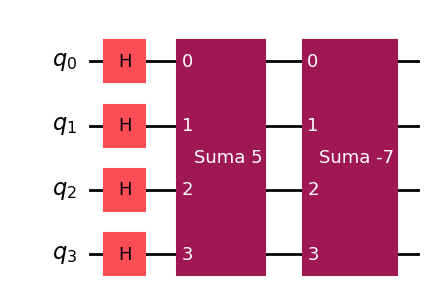

In [ ]:
n = 4

a = 5
b = -7

qc = QuantumCircuit(n)

s1 = pAddGate(a,n)
s2 = pAddGate(-7,n)

# 0 en el espacio de fases
qc.h(range(n))

qc.append(s1, list(range(n)))
qc.append(s2, list(range(n)))

qc.draw('mpl')

In [ ]:
# Vemos el vector de estado
e = Statevector.from_instruction(qc)
e.draw('latex')

<IPython.core.display.Latex object>

In [ ]:
# Aplicamos la QFT inversa
from qiskit.circuit.library import QFTGate

qc_inverso = qc.compose(QFTGate(n).inverse())

e = Statevector.from_instruction(qc_inverso)
e.draw('latex')

<IPython.core.display.Latex object>

## Implementación de puertas controladas

Para finalizar la implementación de la función $g(x)$ tenemos que convertir  las puertas de suma en puertas controladas.

En Qiskit eso se hace con el método `control` de `qiskit.circuit.Gate`

In [3]:
from qiskit.circuit.controlledgate import ControlledGate

def CpAddGate(l: int, n: int, num_ctrl_qubits=1) -> ControlledGate:
  """
  Devuelve un qiskit.circuit.controlledgate.ControlledGate
  que ejecuta una suma +l en el dominio de Fourier
  de un valor entero de n cúbits controlada por
  num_ctrl_qubits.
  n debe ser sufucientemente grande para reprersentar el valor de la suma

  Argumentos:
    l: valor a sumar (int)
    n: numero de cúbits (int)
    num_ctrl_qubits: Numero de bits de control
  """
  qc = QuantumCircuit(n)

  # Le añado una Gate suma l no controlada
  ncgate = pAddGate(l, n)
  qc.append(ncgate, list(range(n)))

  # Convierto el circuito en una puerta controlada
  # con num_ctrl_qubits cúbits de control
  gate = qc.to_gate(label=ncgate.label)
  gate = gate.control(num_ctrl_qubits)

  return(gate)

## Implementación de la función completa

Ya podemos completar la implementación de del circuito que nos devuelve $g(x)=-2x_0x_2-x_1x_2-x_0+2x_1-3x_2$

Además, para la versión final del GAS, necesitamos implementar la versión inversa de este circuito, para la descomputación.

In [51]:
def gcircuit(n: int, nancillas: int, inverse = False) -> QuantumCircuit:
  """
  Creo el circuito para g(x)=-2x_0x_2 -x_1x_2 -x_0 + 2x_1 - 3x_2
  n = nº de variables
  nancillas: ancillas en las que se guarda el resultado
  El resultado se devuelve en base Fourier
  El valor g(x) se devuelve en las ancillas

  inverse: si True devuelve el circuito inverso para la descomputación
  """

  x = QuantumRegister(n, name='x')
  ancillas = QuantumRegister(nancillas, name='ancillas')

  qc = QuantumCircuit(x,ancillas)

  # Lista con los coeficientes y las variables de la función
  parameters = [([x[0],x[2]] , -2),
                ([x[1],x[2]] , -1),
                ([x[0]] , -1),
                ([x[1]] , 2),
                ([x[2]] , -3)]

  # Creo las puertas controladas
  if not inverse:
    puertas = list()
    for p in parameters:
      puertas.append(CpAddGate(p[1], nancillas, len(p[0])))

    # Pongo las ancillas a 0 en el dominio de Fourier
    qc.h(ancillas)

    # Añado las puertas controladas al circuito
    # Los cúbits de control hay que indicarlos como una lista
    # primero los qubits de control, luego los target
    for g in range(len(puertas)):
      qc.append(puertas[g], parameters[g][0]+list(ancillas))

  # Circuito inverso
  else:
    puertas = list()
    # Defino las puertas con el signo cambiado
    for p in parameters:
      puertas.append(CpAddGate(-p[1], nancillas, len(p[0])))
    # Añado las puertas controladas al circuito
    # Los cúbits de control hay que indicarlos como una lista
    # primero los qubits de control, luego los target
    for g in range(len(puertas)-1,-1,-1):
      qc.append(puertas[g], parameters[g][0]+list(ancillas))
    # Añado las Hadamard
    qc.h(ancillas)

  # Devuelvo el circuito
  return(qc)

Veamos que funciona.

In [53]:
# Creo un circuito para probar que funciona
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFTGate
from qiskit.circuit import ClassicalRegister

def gcircuittest(n: int, nancillas:int) -> QuantumCircuit:

  qc = gcircuit(n, nancillas)

  # Le añado una QFT inversa para obtener el resultado
  qc.append(QFTGate(nancillas).inverse(), list(range(n,n+nancillas)))

  # Le añado la medida de las ancillas
  meas = ClassicalRegister(nancillas, 'meas')

  qc.add_register(meas)
  qc.measure(list(range(n, n+nancillas)), meas)

  return(qc)

In [81]:
# Usamos el sampler base de Qiskit (basado en Statevector)
from qiskit.primitives import StatevectorSampler
def g_cuantica(circuit: QuantumCircuit, x: int, shots = 10000) -> int:
  sampler = StatevectorSampler()

  estado_inicial = Statevector.from_int(x, 2**(n+nancillas))

  # Le añado al circuito el estado inicial
  qc = QuantumCircuit(circuit.num_qubits)

  qc.initialize(estado_inicial)
  qc.compose(circuit, inplace=True)

  pub = (qc)
  job = sampler.run([pub], shots=shots, )

  # counts_int: Diccionario con claves=estados (binario), valor=ocurrencias
  counts = job.result()[0].data.meas.get_counts()

  # Estado con mayor probabilidad
  max_prob = max(counts, key=counts.get)

  # Convierte el estado de nancillas bits de str a int
  nbits = len(max_prob)
  valor = int(max_prob, 2)
  result = valor - (valor >> (nbits - 1) << nbits)

  return(result)

In [107]:
n = 3
nancillas = 4

for x in range(2**n):
  qc = gcircuittest(n, nancillas)
  resultado = g_cuantica(qc, x)
  x = bin(x)[2:].zfill(n)
  print(f'g({x}) = {resultado}')


g(000) = 0
g(001) = -1
g(010) = 2
g(011) = 1
g(100) = -3
g(101) = -6
g(110) = -2
g(111) = -5


Lo comparo con los resultados clásicos

In [116]:
def g_clasico(x, nbits):
  # Convertir a binario y quitar '0b'
  bin_str = bin(x)[2:]
  if len(bin_str) > nbits:
    raise ValueError(f"El número {num} necesita más de {bits} bits")
  x = [int(i) for i in bin_str.zfill(nbits)[::-1]]
  g = -2*x[0]*x[2] - x[1]*x[2] - x[0] + 2*x[1] - 3*x[2]
  return(g)

In [118]:
for x in range(2**n):
  resultado = g_clasico(x, n)
  x = bin(x)[2:].zfill(n)
  print(f'g({x}) = {resultado}')


g(000) = 0
g(001) = -1
g(010) = 2
g(011) = 1
g(100) = -3
g(101) = -6
g(110) = -2
g(111) = -5




---



---



---



<a name="oraculocont"></a>

# **Implementación del oráculo (continuación)**

A partir del circuito que inplementa la función, podemos crear el oráculo que devuelva 1 cuando $g(y) \lt g(x_0)$, o, lo que es lo mismo, $g(y)-g(x_0) \lt 0$.

Suponemos $x_0$ y $g(x_0)$ conocidos.

Empezamos implementando el circuito que devuelva $g(y)-g(x_0)$ para  $g(x)=-2x_0x_2-x_1x_2-x_0+2x_1-3x_2$ (continuación)


In [119]:
def restag(n:int, nancillas:int, init_value:int, inverse = False) -> QuantumCircuit:
  """
  Si inverse = False, devuelve el circuito que calcula g(y)-g(x_0)
  El circuito devuelve el resultado en base Z (aplica QFT inversa).

  Si inverse = True, devuelve el circuito inverso para la descomputación

  Parameters:
    n: nº de variables
    nancillas: ancillas en las que se guarda el resultado
    init_value: valor de g(x_0)
  """

  if not inverse:
    # Circuito que implementa g(y)
    qc = gcircuit(n, nancillas)

    # Puerta resta g(x_0)
    qc.append(pAddGate(-init_value, nancillas), list(range(n,n+nancillas)))

    # Uso la transformada inversa de Fourier para obtener el resultado
    qc.append(QFTGate(nancillas).inverse(), list(range(n,n+nancillas)))

  else:
    qc = QuantumCircuit(n+nancillas)
    # Añado la QFT directa
    qc.append(QFTGate(nancillas), list(range(n,n+nancillas)))

    # Puerta suma g(x_0)
    qc.append(pAddGate(init_value, nancillas), list(range(n,n+nancillas)))

    qc.compose(gcircuit(n, nancillas, inverse=True), inplace=True)

  return(qc)

In [120]:
def oraculo(n:int, nancillas:int, init_value:int) -> Gate:
  """
  Devuelve el oráculo completo, como un circuito con n+nancillas+1 cúbit
  Esta ancilla adicional es la salida del oráculo
  """

  qc = QuantumCircuit(n+nancillas+1)

  qc.compose(restag(n,nancillas,init_value), inplace=True)

  # La última de las ancillas es 1 en el caso de g(y)-g(x_0) < 0
  qc.cx(n+nancillas-1, n+nancillas)

  # Uncomputation
  qc.compose(restag(n, nancillas, init_value, inverse=True), inplace=True)

  return(qc.to_gate(label='Oraculo GAS'))




---



---



---



<a name="grover"></a>
# **Uso con el algoritmo de Grover**

Para usar el algoritmo de Grover una vez que tenemos el oráculo, necesitamos las puertas iniciales y el difusor

In [122]:
from qiskit.circuit.library import MCMTGate, ZGate
def difusor(n: int) -> Gate:
    """Difusor de Grover sobre n qubits (devuelve una Gate)."""
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))

    qc = qc.compose(MCMTGate(ZGate(),n-1, 1))

    qc.x(range(n))
    qc.h(range(n))
    return qc.to_gate(label='Difusor')

El circuito completo

In [123]:
from qiskit.circuit import ClassicalRegister
def gas_completo(n: int, nancillas: int, init_value:int, n_grover_iters=1) -> QuantumCircuit:

  # Puertas oráculo y difusor
  gate_oraculo = oraculo(n, nancillas, init_value)
  gate_difusor = difusor(n)

  # El circuito completo
  x = QuantumRegister(n, name='x')
  ancillas = QuantumRegister(nancillas, name='ancillas')
  output =  QuantumRegister(1, name='out')
  meas = ClassicalRegister(n, 'measure')

  qc_gas = QuantumCircuit(x, ancillas, output, meas)


  # Inicializamos las x y rl qbit output
  qc_gas.h(x)
  qc_gas.x(output)
  qc_gas.h(output)

  qc_gas.barrier()

  # Añadimos n_grover_iters oraculo/difusor
  for _ in range(n_grover_iters):
    qc_gas.append(gate_oraculo, list(x)+list(ancillas)+list(output))
    qc_gas.barrier()
    qc_gas.append(gate_difusor, x)
    qc_gas.barrier()

  # Añade la medida del registro x
  qc_gas.measure(x, meas)

  return(qc_gas)

Valor inicial = -3


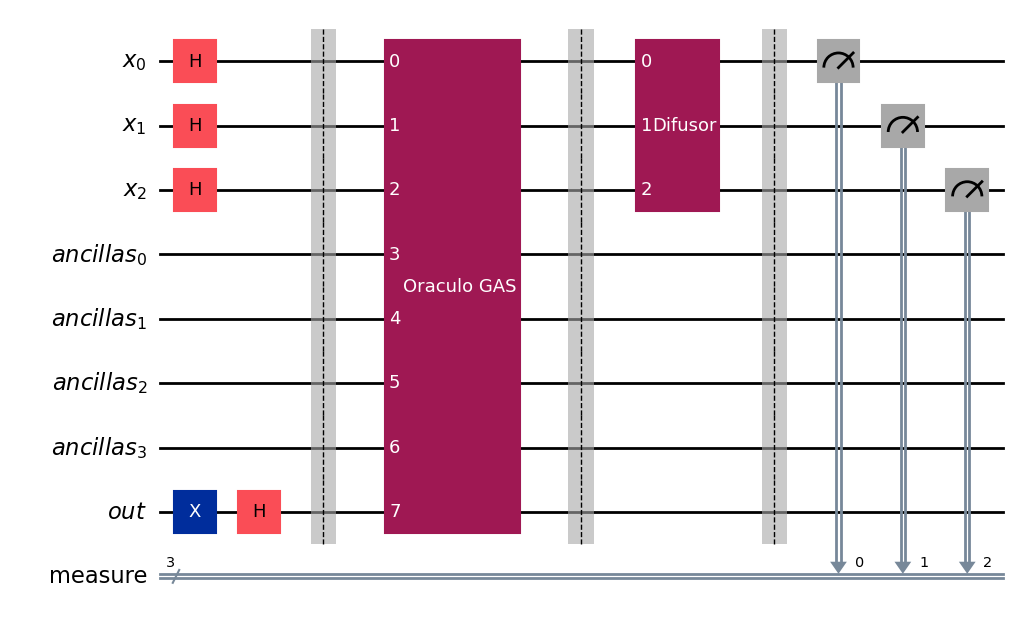

In [124]:
n = 3
nancillas = 4
n_grover_iters = 1

# Tomo x_0 = 4
x = [0,0,1]
init_value = -2*x[0]*x[2]-x[1]*x[2]-x[0]+2*x[1]-3*x[2]

print("Valor inicial = {}".format(init_value))

qc = gas_completo(n, nancillas, init_value, n_grover_iters)

qc.draw('mpl')

In [125]:
# Usamos el sampler base de Qiskit (basado en Statevector)
from qiskit.primitives import StatevectorSampler

def circuit_sampler(circuit, sampler, shots=10000):

  pub = (circuit)
  job = sampler.run([pub], shots=shots)

  # counts_int: Diccionario con claves=estados (binario), valor=ocurrencias
  counts = job.result()[0].data.measure.get_counts()

  # Probabilidades de cada estado (como diccionario Python)
  # Diccionario con claves=estados (binario), valor=probabilidad
  final_distribution = {key: val / shots for key, val in counts.items()}

  # Estado con mayor probabilidad
  max_prob = max(final_distribution, key=final_distribution.get)

  return(max_prob, final_distribution)


In [126]:
# Lo ejecutamos con un StatevectorSampler
sampler = StatevectorSampler()
resultado, data_distribution = circuit_sampler(qc, sampler)

print("Medida más probable = {}".format(resultado))

Medida más probable = 111


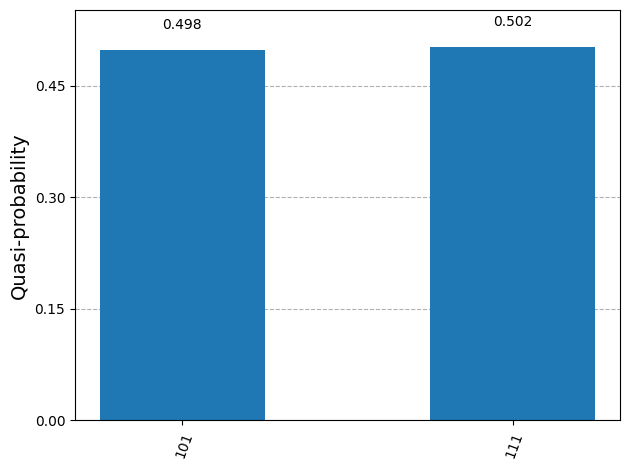

In [127]:
# Vemos la distribución de las muestras
from qiskit.visualization import plot_histogram
display(plot_histogram(data_distribution))

Esto indica que $g(5),q(7) < g(4)$.

La solución a nuestro problema es $5$ ($g(5) = -6$).

Pero vamos a probar el otro valor $x_0=7$

In [128]:
# Tomo x_0 = 7
x = [1,1,1]
init_value = -2*x[0]*x[2]-x[1]*x[2]-x[0]+2*x[1]-3*x[2]

print("Valor inicial = {}".format(init_value))

qc = gas_completo(n, nancillas, init_value, n_grover_iters)

# Lo ejecutamos con un StatevectorSampler
sampler = StatevectorSampler()
resultado, data_distribution = circuit_sampler(qc, sampler)

print("Medida más probable = {}".format(resultado))

Valor inicial = -5
Medida más probable = 101


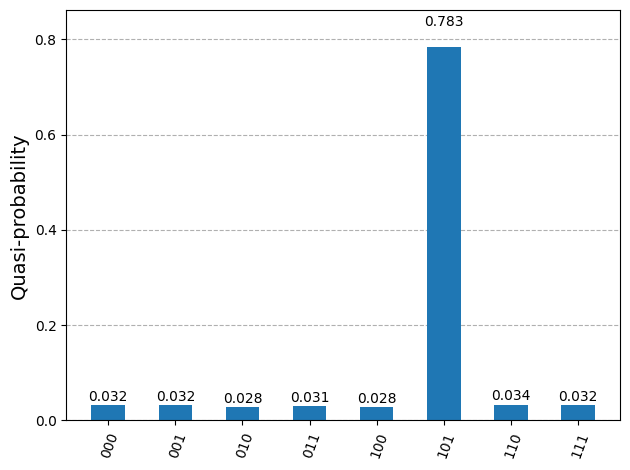

In [129]:
# Vemos la distribución de las muestras
from qiskit.visualization import plot_histogram
display(plot_histogram(data_distribution))